In [1]:
!pip install -U torch  ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 10.9 MB/s eta 0:00:00


In [2]:

# import & downloading the sam weights
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
!mkdir images
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
#!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: False
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2nlrpc8s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2nlrpc8s
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=5431edd0a1109df4ad214d9e2129d073f95490ffee328b1ca05689014b2d0b51
  Stored in directory: /tmp/pip-ephem-wheel-cache-9rxsdlx0/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built seg


0: 384x640 4 persons, 5 ties, 3 cups, 1 chair, 238.2ms
Speed: 1.2ms preprocess, 238.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


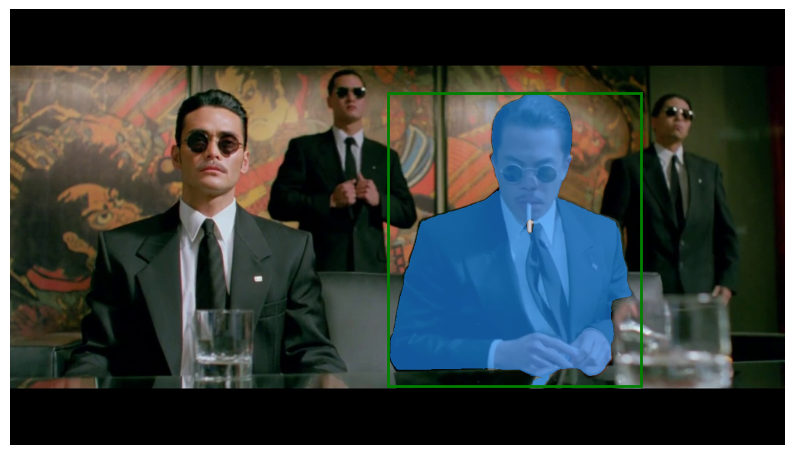

In [5]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt


def yolov8_detection(model, image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
    
    bbox=boxes.xyxy.tolist()[0]
    return bbox, image

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

image_path = '/content/cigarette235.jpg'
model=YOLO('yolov8n.pt')
yolov8_boxex, image = yolov8_detection(model, image_path)

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

input_box = np.array(yolov8_boxex)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

for i, mask in enumerate(masks):
    # Convert the mask to a binary image    
    #binary_mask = mask.cpu().numpy().squeeze().astype(np.uint8)
    binary_mask = torch.from_numpy(masks).squeeze().numpy().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour based on area
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object 
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('bounding_boxe_NEW_137.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))

    mask=segmentation
    
    # load the image
    #width, height = image_path.size
    img = Image.open(image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # write the yolo values to a text file
    with open('yolo_maskformat.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(masks[0], plt.gca())
    show_box(input_box, plt.gca())
    plt.axis('off')
    plt.show()

    # Print the bounding box and segmentation mask
    print("Bounding box:", bbox)
    print("Segmentation mask:", segmentation)

In [6]:
## multi object detection


0: 384x640 4 persons, 5 ties, 3 cups, 1 chair, 169.8ms
Speed: 3.6ms preprocess, 169.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


Bounding box: [627, 138, 400, 486]
yolo [    0.48984     0.19167     0.80156 ...     0.19306     0.68437     0.19167]
Bounding box: [92, 133, 462, 474]
yolo [   0.071875     0.18472     0.43203 ...     0.18611     0.27031     0.18472]
Bounding box: [976, 141, 228, 347]
yolo [     0.7625     0.19583     0.93984     0.67639     0.84609     0.19583     0.84531     0.19722     0.84453     0.19722     0.84375     0.19861     0.84297     0.19861     0.84219         0.2     0.84141         0.2     0.84062     0.20139     0.83984     0.20139     0.83437     0.21111     0.83437      0.2125
     0.83359     0.21389     0.83359     0.21528     0.83203     0.21806     0.83203     0.21944     0.83125     0.22083     0.83125     0.22222     0.82969       0.225     0.82969     0.22778     0.82891     0.22917     0.82891     0.23611     0.82812      0.2375     0.82812     0.24306     0.82734     0.24444
     0.82734     0.24722     0.82656     0.24861     0.82656     0.25694     0.82734     0.25833   

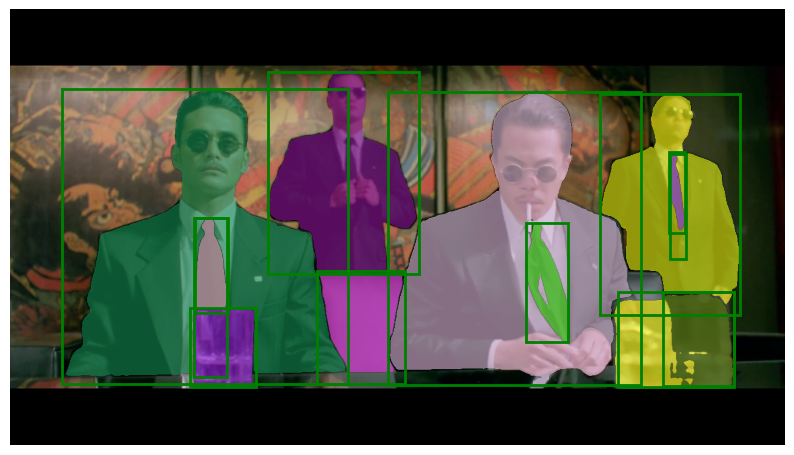

In [8]:
from ultralytics import YOLO
import numpy as np
import cv2
import sys
import torch
from PIL import Image
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

def yolov8_detection(model, image_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
    
    bbox = boxes.xyxy.tolist()
    bbox = [[int(i) for i in box] for box in bbox]
    return bbox, image

image = cv2.imread('/content/cigarette235.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
model=YOLO('/content/yolov8n.pt')

yolov8_boxex, image = yolov8_detection(model, image_path)


sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)
input_boxes = torch.tensor(yolov8_boxex, device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

for i, mask in enumerate(masks):

    binary_mask = masks[i].squeeze().numpy().astype(np.uint8)

    # Find the contours of the mask
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)

    # Get the new bounding box
    bbox = [int(x) for x in cv2.boundingRect(largest_contour)]

    # Get the segmentation mask for object 
    segmentation = largest_contour.flatten().tolist()

    # Write bounding boxes to file in YOLO format
    with open('BBOX_yolo.txt', 'w') as f:
        for contour in contours:
            # Get the bounding box coordinates of the contour
            x, y, w, h = cv2.boundingRect(contour)
            # Convert the coordinates to YOLO format and write to file
            f.write('0 {:.6f} {:.6f} {:.6f} {:.6f}\n'.format((x+w/2)/image.shape[1], (y+h/2)/image.shape[0], w/image.shape[1], h/image.shape[0]))
            f.write('\n')
    mask=segmentation
    
        # load the image
    #width, height = image_path.size
    img = Image.open(image_path)
    width, height = img.size

    # convert mask to numpy array of shape (N,2)
    mask = np.array(mask).reshape(-1,2)

    # normalize the pixel coordinates
    mask_norm = mask / np.array([width, height])

    # compute the bounding box
    xmin, ymin = mask_norm.min(axis=0)
    xmax, ymax = mask_norm.max(axis=0)
    bbox_norm = np.array([xmin, ymin, xmax, ymax])

    # concatenate bbox and mask to obtain YOLO format
    yolo = np.concatenate([bbox_norm, mask_norm.reshape(-1)])

    # compute the bounding box
    # write the yolo values to a text file
    with open('yolomask_format.txt', 'w') as f:
        for val in yolo:
            f.write("{:.6f} ".format(val))
        f.write('\n')

    # Print the bounding box and segmentation mask
    print("Bounding box:", bbox)
    #print("Segmentation mask:", segmentation)
    print("yolo",yolo)
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()